# 05_reexport_to_cellbrowser

Export both HSC and LSK object to cellbrowser - reexported because cluster name of LSKs changed (Progenitor -> Primitive)

Run with this command in docker container

docker run \
--rm \
-d \
--name scanpy2 \
-p 8880:8888 \
-p 8887:8887 \
-e JUPYTER_ENABLE_LAB=YES \
-v /Users/efast/:/home/jovyan/work \
scanpy:1.4.6

## 1) Loading packages + data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import cellbrowser.cellbrowser as cb
import os

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)
# plt.rcParams['figure.figsize']=(5,5) #rescale figures

In [5]:
os.chdir('/home/jovyan/work/Documents/Z_TRASH')

adata = sc.read(
    './sc_objects/LT_preprocessed.h5ad')

In [6]:
adata.var_names_make_unique()

In [7]:
adata

AnnData object with n_obs × n_vars = 15355 × 14408 
    obs: 'sample', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'batch', 'rXist', 'leiden', 'umap_density_sample'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'sex_sample_colors', 'umap', 'umap_density_sample_params'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

## Check the previous clustering (Leiden 6 clusters 25 KNN, 0.4 resolution)

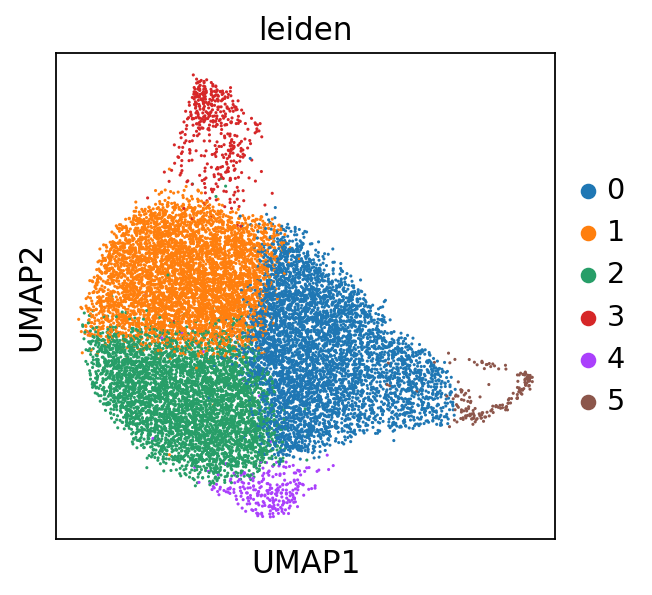

In [8]:
sc.pl.umap(adata, color='leiden')

In [9]:
# rename cluster categories
adata.rename_categories('leiden', ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle'])

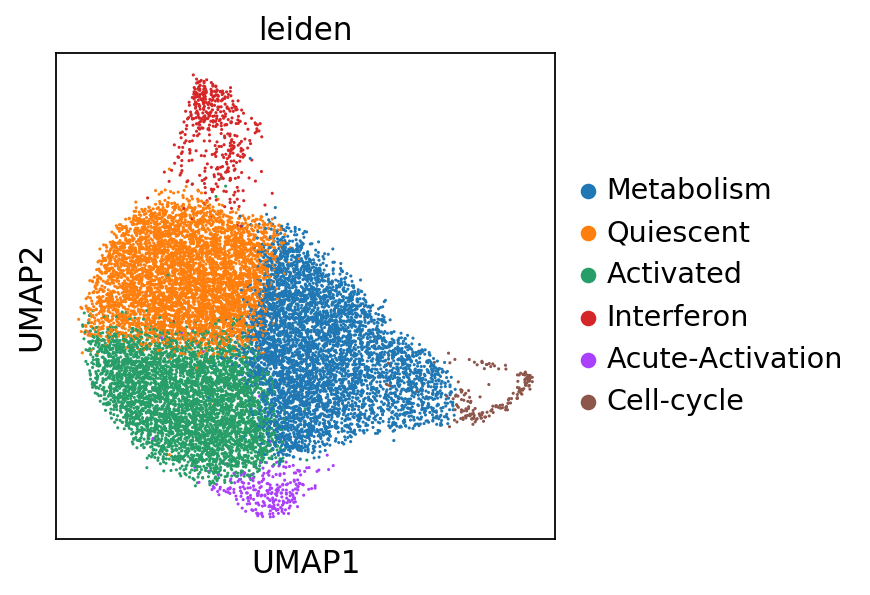

In [10]:
sc.pl.umap(adata, color='leiden')

In [11]:
adata.obs['louvain']=adata.obs['leiden']

# rename LT category from LT into HSC
HSPC_renaming = {'pIC': 'poly (I:C)', 'GCSF': 'G-CSF', 'indo': 'indomethacin', 'ct' : 'control'} # dictionary for renaming
adata.obs = adata.obs.replace(HSPC_renaming)

In [12]:
adata.obs.head()

,sample,n_counts,log_counts,n_genes,percent_mito,Female,Female_cat,Female_str,sex_sample,batch,rXist,leiden,umap_density_sample,louvain
AAACCCACACAGAGCA,control,7698.0,8.948846,2664,0.049227,False,False,false,ct_false,batch1,0.078504,Activated,0.769843,Activated
AAACCCAGTATCGTGT,control,8031.0,8.991189,2539,0.054656,False,False,false,ct_false,batch1,0.078504,Quiescent,0.978590,Quiescent
AAACCCAGTCTGTCAA,control,9978.0,9.208138,3203,0.050210,True,True,true,ct_true,batch1,3.259153,Metabolism,0.493924,Metabolism
AAACCCAGTGAACTAA,control,8042.0,8.992682,2779,0.061288,True,True,true,ct_true,batch1,3.019387,Quiescent,0.920127,Quiescent
AAACCCATCCAATCTT,control,17477.0,9.769098,4703,0.052159,True,True,true,ct_true,batch1,0.525301,Activated,0.931675,Activated


## Look which signatures are enriched in the different clusters

In [13]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

ranking genes


... storing 'sample' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


In [14]:
# which genes are enriched in which groups
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']})
#.head(5)

In [15]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,Metabolism,Quiescent,Activated,Interferon,Acute-Activation,Cell-cycle
0,Ran,Txnip,Nr4a1,Iigp1,Cebpb,H2afz
1,Eif5a,Rps24,Hes1,Isg15,Tsc22d3,Hmgb2
2,Mif,Rplp1,H3f3b,Ifit1,Plaur,Stmn1
3,Ncl,Fau,Ier2,Gbp7,Ifngr1,Hmgb1
4,Ppia,Mllt3,Junb,Oasl2,Anks1,Ptma
5,Nme1,Rps14,Klf2,Gm4951,Fosl2,Mki67
6,Pfn1,Rpl9,Fos,Ifitm3,Rps27,H2afv
7,Ptma,Rps27,Smad7,Rtp4,Ctla2a,Cks1b
8,Anp32b,Rpl30,Nr4a2,Igtp,Tsc22d1,Ran
9,Slc25a5,Pdzk1ip1,Rgs2,Ifi203,Klf13,Spc24


In [16]:
adata.obs = adata.obs[['sample',
                         'n_counts',
                         'log_counts',
                         'n_genes',
                         'percent_mito',
                         'Female',
                         'louvain']]

In [17]:
# save adata a new object
adata.write('./sc_objects/HSC_cellbrowser.h5ad')

# export adata object to cellbrowser object
cb.scanpyToCellbrowser(adata, "./cellbrowser/HSC", "HSC")

INFO:root:Writing scanpy matrix (15355 cells, 14408 genes) to ./cellbrowser/HSC/exprMatrix.tsv.gz
INFO:root:Transposing matrix
INFO:root:Writing gene-by-gene, without using pandas
INFO:root:Writing 14408 genes in total
INFO:root:Wrote 0 genes
INFO:root:Wrote 2000 genes
INFO:root:Wrote 4000 genes
INFO:root:Wrote 6000 genes
INFO:root:Wrote 8000 genes
INFO:root:Wrote 10000 genes
INFO:root:Wrote 12000 genes
INFO:root:Wrote 14000 genes
INFO:root:Writing Fruchterman Reingold coords to ./cellbrowser/HSC/fr_coords.tsv
INFO:root:Writing t-SNE coords to ./cellbrowser/HSC/tsne_coords.tsv
INFO:root:Writing UMAP coords to ./cellbrowser/HSC/umap_coords.tsv
INFO:root:Writing ./cellbrowser/HSC/markers.tsv
INFO:root:Generating ./cellbrowser/HSC/quickGenes.tsv from ./cellbrowser/HSC/markers.tsv
INFO:root:Reading ./cellbrowser/HSC/markers.tsv: assuming marker file format (cluster, gene, score) + any other fields
INFO:root:./cellbrowser/HSC/cellbrowser.conf already exists, not overwriting. Remove and re-r

## LSKs/MPPs

In [18]:
adata = sc.read(
    './sc_objects/MPP_preprocessed.h5ad')

In [19]:
adata.var_names_make_unique()

In [20]:
adata

AnnData object with n_obs × n_vars = 8191 × 13827 
    obs: 'assignment', 'batch', 'counts', 'demux_type', 'hto_type', 'rna_type', 'sample', 'select_cells', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'rXist', 'leiden', 'umap_density_sample', 'umap_density_assignment'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'assignment_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'sex_sample_colors', 'umap', 'umap_density_assignment_params', 'umap_density_sample_params'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

## Check the previous clustering (Leiden 6 clusters 25 KNN, 0.4 resolution)

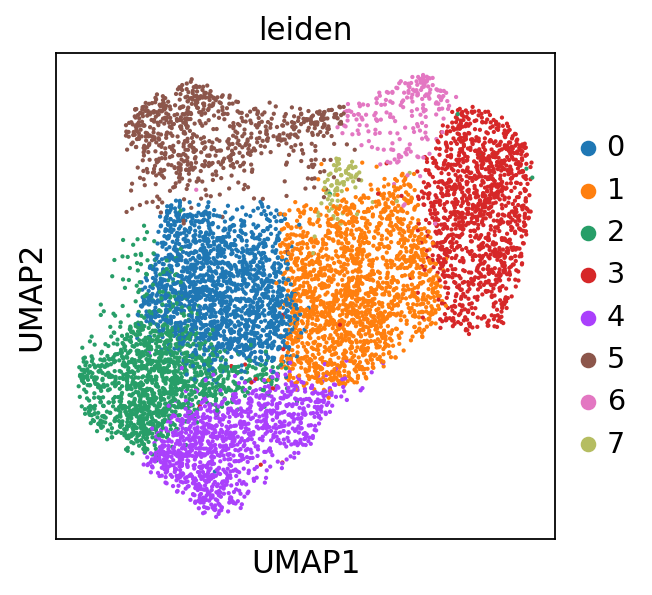

In [21]:
sc.pl.umap(adata, color='leiden')

In [25]:
# rename cluster categories
adata.rename_categories('leiden', ['LSK-Primed', 'LSK-Metabolism', 'LSK-Primitive', 'LSK-Cell-cycle', 'LSK-Acute-Activation', 
                                   'LSK-Interferon', 'LSK-Interferon cell-cycle','LSK-Myeloid'])

... storing 'assignment' as categorical
... storing 'sample' as categorical


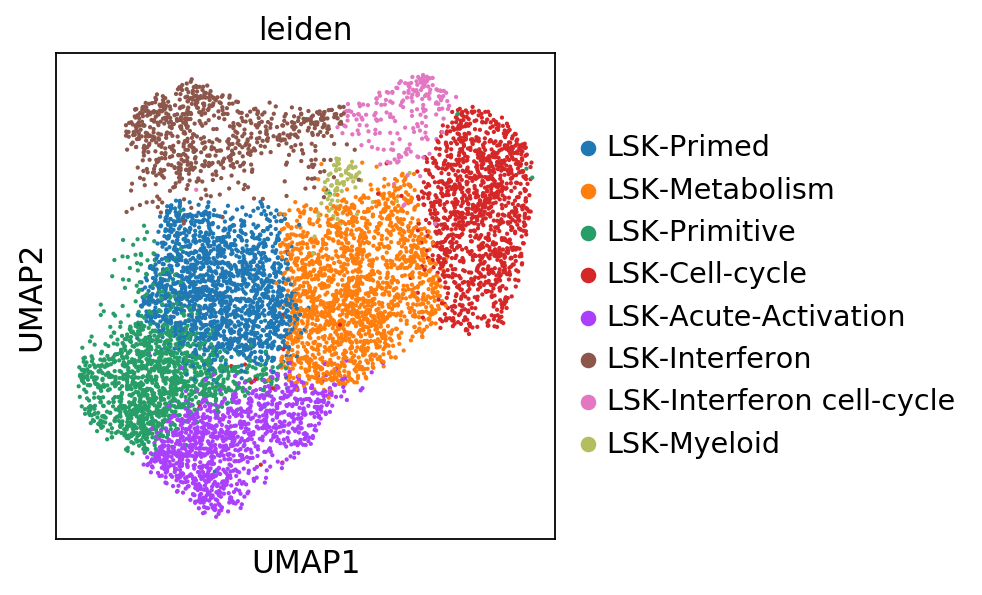

In [26]:
sc.pl.umap(adata, color='leiden')

In [27]:
# rename cluster from leiden into louvain

adata.obs['louvain']=adata.obs['leiden']

# rename some names
HSPC_renaming = {'pIC': 'poly (I:C)', 'GCSF': 'G-CSF', 'indo': 'indomethacin', 'LT': 'HSC', 'ct' : 'control'} # dictionary for renaming

adata.obs = adata.obs.replace(HSPC_renaming)

## Look which signatures are enriched in the different clusters

In [28]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


In [29]:
# which genes are enriched in which groups
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']})
#.head(5)

In [30]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,LSK-Primed,LSK-Metabolism,LSK-Primitive,LSK-Cell-cycle,LSK-Acute-Activation,LSK-Interferon,LSK-Interferon cell-cycle,LSK-Myeloid
0,Rps9,Dut,Ftl1,Hmgb2,Ctla2a,Serpina3g,Cxcl10,Tmsb4x
1,Rpl18a,Lig1,Ifitm1,Ube2c,Ifngr1,Cxcl10,Parp14,Tyrobp
2,Rpl10,Tyms,Jund,Cdca8,Tsc22d3,Rsad2,Irf1,Ap3s1
3,Rpl32,Ppia,Hlf,Nusap1,Plaur,Iigp1,Gbp5,Taldo1
4,Ogt,Ran,Malat1,Ccnb2,Cebpb,Serpina3f,Iigp1,Lgals1
5,Rps18,Ranbp1,Rps14,Cenpf,Neurl3,Ifit1,Cd69,Tspo
6,Rpl17,Dctpp1,Rpl21,Cks2,Gm10076,Isg15,Usp18,Fcer1g
7,Rps11,Ybx1,Fos,Birc5,Cytip,Igtp,Gbp7,Clec12a
8,Rps14,Gmnn,Cd63,Mki67,Pde4b,Gbp5,Igtp,Ctsg
9,Rpl18,Uhrf1,Ier2,Tubb4b,Stk17b,Ifi203,Isg15,Rab44


In [31]:
adata.obs.head()

,assignment,batch,counts,demux_type,hto_type,rna_type,sample,select_cells,n_counts,log_counts,...,percent_mito,Female,Female_cat,Female_str,sex_sample,rXist,leiden,umap_density_sample,umap_density_assignment,louvain
AAACGAAGTTGGACCC-0,MPP3/4,batch1,902.0,singlet,background,signal,control,1.0,13508.0,9.511259,...,0.057805,True,True,true,ct_true,3.158928,LSK-Metabolism,0.637315,0.847134,LSK-Metabolism
AAAGGATCACGCTGAC-0,MPP,batch1,869.0,singlet,background,signal,control,1.0,18172.0,9.807637,...,0.049802,True,True,true,ct_true,3.078445,LSK-Primed,0.783623,0.335968,LSK-Primed
AAAGGATGTAGTCTGT-0,MPP3/4,batch1,694.0,singlet,background,signal,control,1.0,8688.0,9.070044,...,0.059602,True,True,true,ct_true,3.206680,LSK-Primed,0.866588,0.514442,LSK-Primed
AAAGGGCAGCAGCGAT-0,MPP,batch1,848.0,singlet,background,signal,control,1.0,8510.0,9.049468,...,0.056965,False,False,false,ct_false,-0.049406,LSK-Primed,0.675819,0.257006,LSK-Primed
AAAGGTATCTTCGACC-0,MPP3/4,batch1,3446.0,singlet,signal,signal,control,1.0,15875.0,9.672815,...,0.046851,True,True,true,ct_true,2.978796,LSK-Cell-cycle,0.668953,0.709803,LSK-Cell-cycle


In [32]:
#select relevant annotations

adata.obs = adata.obs[['assignment', 'sample', 'n_counts', 'n_genes', 
                       'percent_mito', 'Female', 'louvain']]

In [33]:
adata.obs.columns = ['surface_marker', 'sample', 'n_counts', 'n_genes', 
                       'percent_mito', 'Female', 'louvain']

In [34]:
# save adata a new object
adata.write('./sc_objects/LSK_cellbrowser.h5ad')

cb.scanpyToCellbrowser(adata, "./cellbrowser/LSK", "LSK")

INFO:root:Writing scanpy matrix (8191 cells, 13827 genes) to ./cellbrowser/LSK/exprMatrix.tsv.gz
INFO:root:Transposing matrix
INFO:root:Writing gene-by-gene, without using pandas
INFO:root:Writing 13827 genes in total
INFO:root:Wrote 0 genes
INFO:root:Wrote 2000 genes
INFO:root:Wrote 4000 genes
INFO:root:Wrote 6000 genes
INFO:root:Wrote 8000 genes
INFO:root:Wrote 10000 genes
INFO:root:Wrote 12000 genes
INFO:root:Writing Fruchterman Reingold coords to ./cellbrowser/LSK/fr_coords.tsv
INFO:root:Writing t-SNE coords to ./cellbrowser/LSK/tsne_coords.tsv
INFO:root:Writing UMAP coords to ./cellbrowser/LSK/umap_coords.tsv
INFO:root:Writing ./cellbrowser/LSK/markers.tsv
INFO:root:Generating ./cellbrowser/LSK/quickGenes.tsv from ./cellbrowser/LSK/markers.tsv
INFO:root:Reading ./cellbrowser/LSK/markers.tsv: assuming marker file format (cluster, gene, score) + any other fields
INFO:root:./cellbrowser/LSK/cellbrowser.conf already exists, not overwriting. Remove and re-run command to recreate.


## make cellbrowser

downloaded https://cells.ucsc.edu/downloads/cellbrowserData/genes/gencode-mouse.symbols.tsv.gz
into the following folder: /home/jovyan/cellbrowserData/genes/gencode-mouse.symbols.tsv.gz

(couldn't use wget because there was some SSL certificate error

In [37]:

os.chdir('/home/jovyan/work/Documents/Z_TRASH/cellbrowser/HSC')

In [38]:
!pwd

/home/jovyan/work/Documents/Z_TRASH/cellbrowser/HSC


In [39]:
! cbBuild --init

INFO:root:/home/jovyan/work/Documents/Z_TRASH/cellbrowser/HSC/cellbrowser.conf already exists, not overwriting
INFO:root:/home/jovyan/work/Documents/Z_TRASH/cellbrowser/HSC/desc.conf already exists, not overwriting


In [41]:
os.chdir('/home/jovyan/work/Documents/Z_TRASH/cellbrowser/LSK')

In [42]:
! cbBuild --init

INFO:root:/home/jovyan/work/Documents/Z_TRASH/cellbrowser/LSK/cellbrowser.conf already exists, not overwriting
INFO:root:/home/jovyan/work/Documents/Z_TRASH/cellbrowser/LSK/desc.conf already exists, not overwriting


##### general

This is an interactive app to explore the scRNAseq data from HSCs and LSK cells that have been treated with various niche stimulants. Code for analysis and to generate the app is available here: https://github.com/evafast/scrnaseq_paper

#### added this text to the .desc.conf

##### HSC

abstract = "Single cell clustering of HSCs from male and female mice treated with poly(I:C), G-CSF, dmPGE2, indomethacin and control"

methods = "Mice were treated with stimulants (G-CSF, poly(I:C), dmPGE2) for 2h and Prostaglandin inhibitor indomethacin for 1 week. HSCs were sorted with the following markers lineage -, ckit+, Sca1+, CD48-, CD150+, CD34-. ScRNAseq libraries were prepared using the 10x genomics platform. Clustering was performed using the Leiden algorithm (labelled as Louvain)"

##### LSK

abstract = "Single cell clustering of LSKs from male and female mice treated with poly(I:C), G-CSF, dmPGE2, indomethacin and control"

methods = "Mice were treated with stimulants (G-CSF, poly(I:C), dmPGE2) for 2h and Prostaglanding in inhibitor indomethacin for 1 week. HSCs and MPPs were sorted from the same mice. The following markers define the subpopulations:
HSCs: lineage -, ckit+, Sca1+, CD48-, CD150+, CD34-
MPP1: lineage -, ckit+, Sca1+, CD48-, CD150+, CD34+
MPP2: lineage -, ckit+, Sca1+, CD48+, CD150+ 
MPP3/4: lineage -, ckit+, Sca1+, CD48+, CD150-
MPP: lineage -, ckit+, Sca1+, CD48-, CD150-

After sorting MPP populations were labelled with HTO hashtag antibodies (https://cite-seq.com/cell-hashing/) for 30 minutes on ice. After washing MPP populations were pooled in equal ratios (also male and female cells) for 10x droplet formation. HSCs were processed in a separate 10x reaction. For computational analysis MPPs were first demultiplexed and then pooled at ratios according to the FACS sort. Clustering was performed using the Leiden algorithm (labelled as Louvain)"


TODO: add the link to bioRxiv

In [44]:
cb.build("/home/jovyan/work/Documents/Z_TRASH/cellbrowser/HSC", "/home/jovyan/work/Documents/Z_TRASH/cellbrowser/app")

INFO:root:dataRoot is not set in ~/.cellbrowser.conf. Dataset hierarchies are not supported.
INFO:root:Determining if /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/HSC/exprMatrix.tsv.gz needs to be created
INFO:root:Reading headers of file /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/HSC/exprMatrix.tsv.gz
INFO:root:current input matrix looks identical to previously processed matrix, same file size, same sample names
INFO:root:/home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/HSC/meta.tsv has the same md5 as in /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/HSC/dataset.json, no need to rebuild meta data
INFO:root:Reading sample names from /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/HSC/meta.tsv
INFO:root:Reading sample names from /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/HSC/meta.tsv
INFO:root:Loading old config from /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/HSC/dataset.json
INFO:root:Matrix and meta sample names have not changed, not inde

In [45]:
cb.build("/home/jovyan/work/Documents/Z_TRASH/cellbrowser/LSK", "/home/jovyan/work/Documents/Z_TRASH/cellbrowser/app")

INFO:root:dataRoot is not set in ~/.cellbrowser.conf. Dataset hierarchies are not supported.
INFO:root:Determining if /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/LSK/exprMatrix.tsv.gz needs to be created
INFO:root:Reading headers of file /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/LSK/exprMatrix.tsv.gz
INFO:root:current input matrix looks identical to previously processed matrix, same file size, same sample names
INFO:root:/home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/LSK/meta.tsv has the same md5 as in /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/LSK/dataset.json, no need to rebuild meta data
INFO:root:Reading sample names from /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/LSK/meta.tsv
INFO:root:Reading sample names from /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/LSK/meta.tsv
INFO:root:Loading old config from /home/jovyan/work/Documents/Z_TRASH/cellbrowser/app/LSK/dataset.json
INFO:root:Matrix and meta sample names have not changed, not inde

In [46]:
cb.stop()

In [47]:
## this tests the website
cb.serve("/home/jovyan/work/Documents/Z_TRASH/cellbrowser/app", 8887)